In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('max_columns', None)

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [2]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [3]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [4]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']

def train_test_split(random_state):
    global X_train, y_train, sensitive_train
    global X_test, y_test, sensitive_test


    index_train = list(df.sample(frac=0.8, random_state=random_state).index)
    index_test = list(df.drop(index=index_train).index)

    X_train = X.drop(index=index_test).to_numpy()
    y_train = y.drop(index=index_test).to_numpy()
    sensitive_train = sensitive.drop(index=index_test).to_numpy()

    X_test = X.drop(index=index_train).to_numpy()
    y_test = list(y.drop(index=index_train).to_numpy())
    sensitive_test = sensitive.drop(index=index_train).to_numpy()
train_test_split(1)

In [5]:
def descr_clf(sensit, y):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, clf(𝑥) = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, clf(𝑥) = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1, n_zero, n_one= 0, 0, 0, 0
    for i in range(0, len(y)):
        if sensit[i] == 0.0:
            n_zero+=1
            if y[i] == 1.0:
                p0+=1
        elif sensit[i] == 1.0:
            n_one+=1
            if y[i] == 1.0:
                p1+=1

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def descr(tids):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, 𝑥.Class = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, 𝑥.Class = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1, n_zero, n_one= 0, 0, 0, 0
    for i in tids:
        if sensitive_train[i] == 0.0:
            n_zero+=1
            if y_train[i] == 1.0:
                p0+=1
        elif sensitive_train[i] == 1.0:
            n_one+=1
            if y_train[i] == 1.0:
                p1+=1

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def descr_add(tids):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, 𝑥.Class = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, 𝑥.Class = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1 = 0, 0
    for i in tids:
        if sensitive_train[i] == 0.0:
            if y_train[i] == 1.0:
                p0+=1
        elif sensitive_train[i] == 1.0:
            if y_train[i] == 1.0:
                p1+=1

    cnt = np.unique(sensitive_train, return_counts=True)[1]
    n_zero = cnt[0]
    n_one = cnt[1]

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def error(tids, k=1):
    classes, supports = np.unique(y_train.take(tids), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex], classes[maxindex]

def error1(tids, k=10):
    classes, supports = np.unique(y_train.take(tids), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex] + abs(descr_add(tids)) * k, classes[maxindex]

def error2(tids, k=100):
    classes, supports = np.unique(y_train.take(tids), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex] + abs(descr_add(tids)) * k, classes[maxindex]

def error3(tids, k=500):
    classes, supports = np.unique(y_train.take(list(tids)), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex] + abs(descr_add(tids)) * k, classes[maxindex]

def error4(tids, k=1000):
    classes, supports = np.unique(y_train.take(list(tids)), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex] + abs(descr_add(tids)) * k, classes[maxindex]


descr(range(0,len(X_train)))


-0.32561904761904764

In [6]:
result = pd.DataFrame(columns=['function', 'depth', 'clf.error_', 'clf.accuracy_', 'accuracy_train', "accuracy_test", 'discrimination_train', 'discrimination_test', "duration", "min_supp", "random_state"])

if True:
    result = pd.read_csv('save/lawsuit_k')
else:
    for depth in range(1, 8):
        #for min_supp in range(1, len(X_train), int(len(X_train)/4)):
        for min_supp in range(1,2):
            for random_state in range(1, 101, 2):
                if random_state in [17, 35, 43, 71, 91]:
                    continue
                train_test_split(random_state)

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error(list(tids)), min_sup=min_supp, time_limit=600)
                print(f"### Depth: {depth} state: {random_state} error ###")
                start = time.perf_counter()
                print(f"Model building...")
                clf.fit(X_train, list(y_train))
                duration = time.perf_counter() - start
                print("Model built. Duration of building =", round(duration, 4))
                print("clf.accuracy_ =", round(clf.accuracy_, 4))
                y_pred_train = clf.predict(X_train)
                accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
                print("Accuracy DL8.5 on training set =", accuracy_train)
                y_pred_test = clf.predict(X_test)
                accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
                print("Accuracy DL8.5 on test set =", accuracy_test)
                descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
                print("Discrimination of classifier on train", round(descr_clf(sensitive_train, y_pred_train), 4))
                descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
                print("Discrimination of classifier on test", round(descr_clf(sensitive_test, y_pred_test), 4))
                print(f"error: {clf.error_}")

                result.loc[len(result.index)] = ["error", depth, clf.error_, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

                print()

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error1(list(tids)), min_sup=min_supp, time_limit=600)
                print(f"### Depth: {depth} state: {random_state} error1 ###")
                start = time.perf_counter()
                print(f"Model building...")
                clf.fit(X_train, list(y_train))
                duration = time.perf_counter() - start
                print("Model built. Duration of building =", round(duration, 4))
                print("clf.accuracy_ =", round(clf.accuracy_, 4))
                y_pred_train = clf.predict(X_train)
                accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
                print("Accuracy DL8.5 on training set =", accuracy_train)
                y_pred_test = clf.predict(X_test)
                accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
                print("Accuracy DL8.5 on test set =", accuracy_test)
                descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
                print("Discrimination of classifier on train", round(descr_clf(sensitive_train, y_pred_train), 4))
                descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
                print("Discrimination of classifier on test", round(descr_clf(sensitive_test, y_pred_test), 4))
                print(f"error: {clf.error_}")

                result.loc[len(result.index)] = ["error1", depth, clf.error_, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

                print()

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error2(list(tids)), min_sup=min_supp, time_limit=600)
                print(f"### Depth: {depth} state: {random_state} error2 ###")
                start = time.perf_counter()
                print(f"Model building...")
                clf.fit(X_train, list(y_train))
                duration = time.perf_counter() - start
                print("Model built. Duration of building =", round(duration, 4))
                print("clf.accuracy_ =", round(clf.accuracy_, 4))
                y_pred_train = clf.predict(X_train)
                accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
                print("Accuracy DL8.5 on training set =", accuracy_train)
                y_pred_test = clf.predict(X_test)
                accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
                print("Accuracy DL8.5 on test set =", accuracy_test)
                descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
                print("Discrimination of classifier on train", round(descr_clf(sensitive_train, y_pred_train), 4))
                descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
                print("Discrimination of classifier on test", round(descr_clf(sensitive_test, y_pred_test), 4))
                print(f"error: {clf.error_}")

                result.loc[len(result.index)] = ["error2", depth, clf.error_, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

                print()

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error3(list(tids)), min_sup=min_supp, time_limit=600)
                print(f"### Depth: {depth} state: {random_state} error3 ###")
                start = time.perf_counter()
                print(f"Model building...")
                clf.fit(X_train, list(y_train))
                duration = time.perf_counter() - start
                print("Model built. Duration of building =", round(duration, 4))
                print("clf.accuracy_ =", round(clf.accuracy_, 4))
                y_pred_train = clf.predict(X_train)
                accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
                print("Accuracy DL8.5 on training set =", accuracy_train)
                y_pred_test = clf.predict(X_test)
                accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
                print("Accuracy DL8.5 on test set =", accuracy_test)
                descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
                print("Discrimination of classifier on train", round(descr_clf(sensitive_train, y_pred_train), 4))
                descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
                print("Discrimination of classifier on test", round(descr_clf(sensitive_test, y_pred_test), 4))
                print(f"error: {clf.error_}")

                result.loc[len(result.index)] = ["error3", depth, clf.error_, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

                print()

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error4(list(tids)), min_sup=min_supp, time_limit=600)
                print(f"### Depth: {depth} state: {random_state} error4 ###")
                start = time.perf_counter()
                print(f"Model building...")
                clf.fit(X_train, list(y_train))
                duration = time.perf_counter() - start
                print("Model built. Duration of building =", round(duration, 4))
                print("clf.accuracy_ =", round(clf.accuracy_, 4))
                y_pred_train = clf.predict(X_train)
                accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
                print("Accuracy DL8.5 on training set =", accuracy_train)
                y_pred_test = clf.predict(X_test)
                accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
                print("Accuracy DL8.5 on test set =", accuracy_test)
                descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
                print("Discrimination of classifier on train", round(descr_clf(sensitive_train, y_pred_train), 4))
                descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
                print("Discrimination of classifier on test", round(descr_clf(sensitive_test, y_pred_test), 4))
                print(f"error: {clf.error_}")

                result.loc[len(result.index)] = ["error4", depth, clf.error_, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

                print()
    result.to_csv('save/lawsuit_k', index=False)

In [7]:
result = result.sort_values(['function', 'depth', 'min_supp'])
result

,function,depth,clf.error_,clf.accuracy_,accuracy_train,accuracy_test,discrimination_train,discrimination_test,duration,min_supp,random_state
0,error,1,51.000000,0.755981,0.7560,0.7308,0.1565,0.2667,0.004900,1,1
5,error,1,48.000000,0.770335,0.7703,0.6731,0.2345,0.0461,0.003102,1,3
10,error,1,49.000000,0.765550,0.7656,0.6923,0.1796,0.1726,0.002738,1,5
15,error,1,51.000000,0.755981,0.7560,0.7308,0.1858,0.1379,0.003531,1,7
20,error,1,54.000000,0.741627,0.7416,0.7885,0.1446,0.2974,0.005846,1,9
...,...,...,...,...,...,...,...,...,...,...,...
1554,error4,7,342.990204,-0.641101,0.8852,0.9038,0.2661,0.1514,2.965466,1,89
1559,error4,7,320.553680,-0.533750,0.8947,0.8846,0.2242,0.4804,2.812008,1,93
1564,error4,7,372.777985,-0.783627,0.9091,0.8269,0.2569,0.1085,2.753715,1,95
1569,error4,7,358.635620,-0.715960,0.9234,0.8269,0.2581,0.3077,2.672647,1,97


# Mean of random_state

In [8]:
plt.rcParams['figure.figsize'] = [9, 6]
def print_plot_mean(x_axe, y_axe, r, s1, s2):
    plt.figure(figsize= (9, 6))
    r = r.loc[r["min_supp"] == 1]
    style = ['solid', 'dotted', ':','-.', 'dashed']
    k_val = ['1', '10', '100','500', '1000']
    fig, ax = plt.subplots()
    for function in [ "error", "error1", "error2", "error3", "error4"]:
        x_values = list()
        y_values = list()

        for depth in r['depth'].unique():
            df1 = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            y_values.append(df1[y_axe].mean())

        plt.plot(r['depth'].unique(), y_values, label = "k="+k_val.pop(0), linestyle=style.pop(0))


    ax.set_xlabel(x_axe)
    ax.set_ylabel(y_axe)
    ax.legend()
    ax.set_ylim(s1, s2)
    plt.show()

<Figure size 648x432 with 0 Axes>

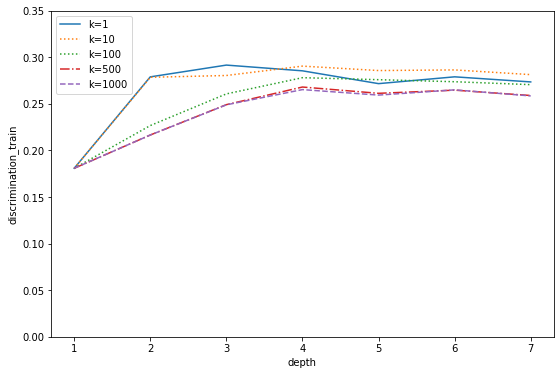

In [9]:
print_plot_mean("depth", "discrimination_train", result, 0, 0.35)

<Figure size 648x432 with 0 Axes>

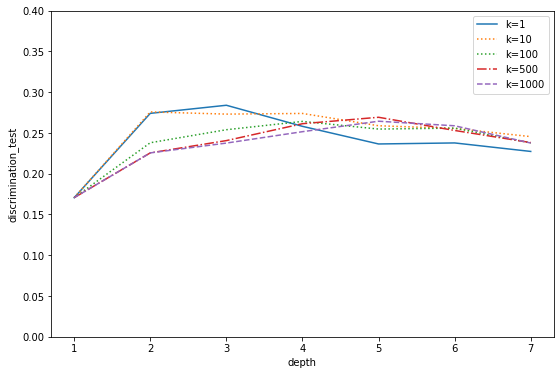

In [10]:
print_plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

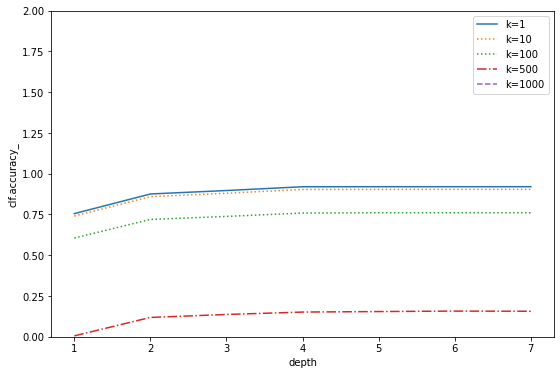

In [11]:
print_plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

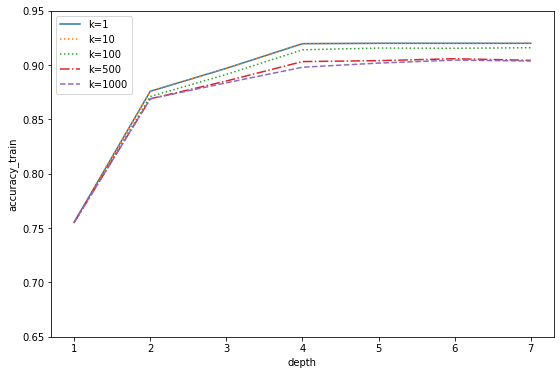

In [12]:
print_plot_mean("depth", "accuracy_train", result, 0.65, 0.95)

<Figure size 648x432 with 0 Axes>

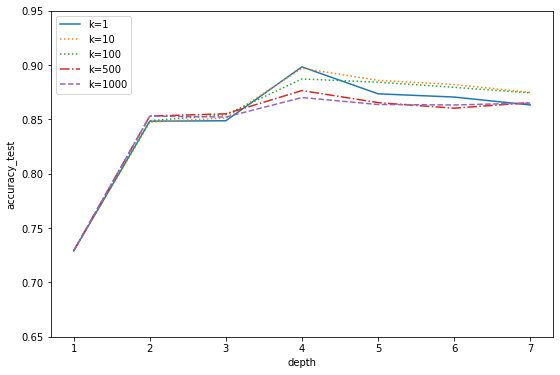

In [13]:
print_plot_mean("depth", "accuracy_test", result, 0.65, 0.95)

In [14]:
def print_plot(x_axe, y_axe, r):
    plt.figure(figsize= (9, 6))
    r = r.loc[r["min_supp"] == 1]
    for function in ["error", "error1", "error2", "error3", "error4"]:
        x_values = list()
        y_values = list()

        for depth in r['depth'].unique():
            df1 = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            y_values.append(df1[y_axe].mean())
            x_values.append(df1[x_axe].mean())
        plt.plot(x_values, y_values, label = function)

    plt.xlabel(x_axe)
    plt.ylabel(y_axe)
    plt.legend()

    plt.show()

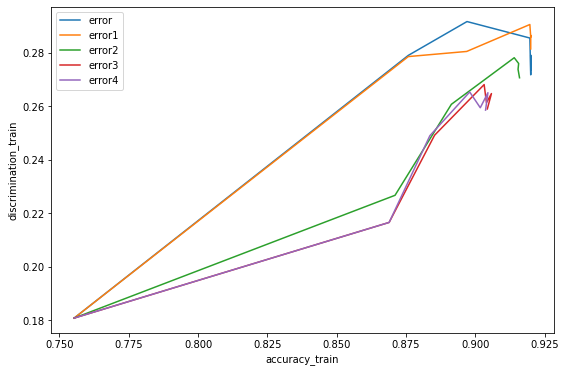

In [15]:
print_plot("accuracy_train", "discrimination_train", result)

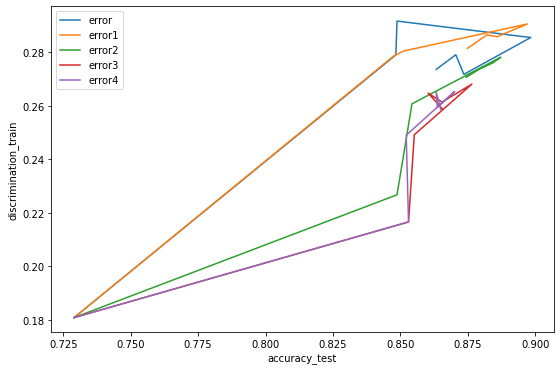

In [16]:
print_plot("accuracy_test", "discrimination_train", result)

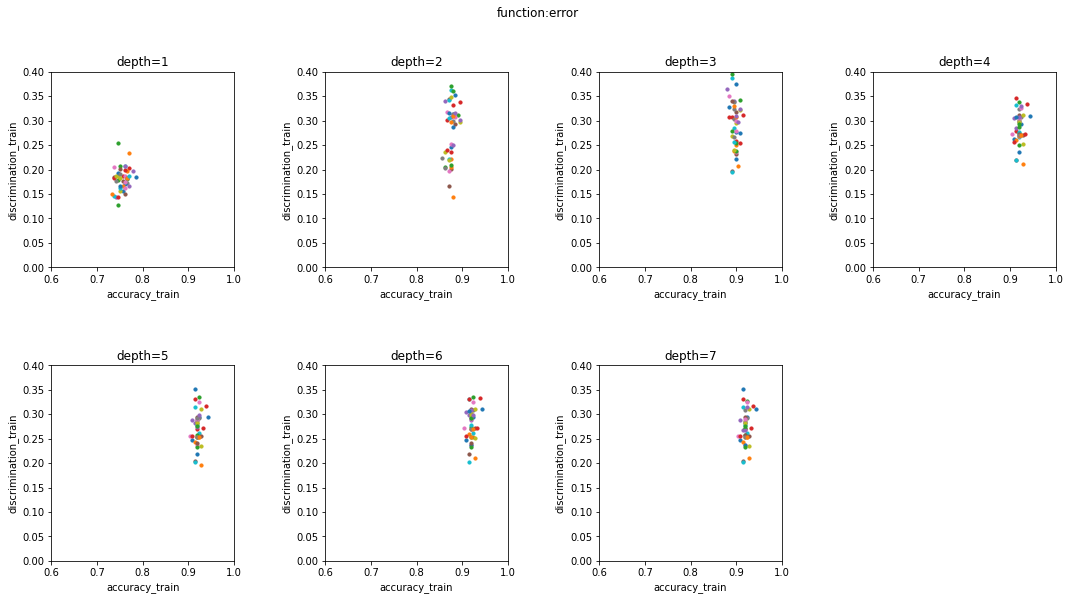

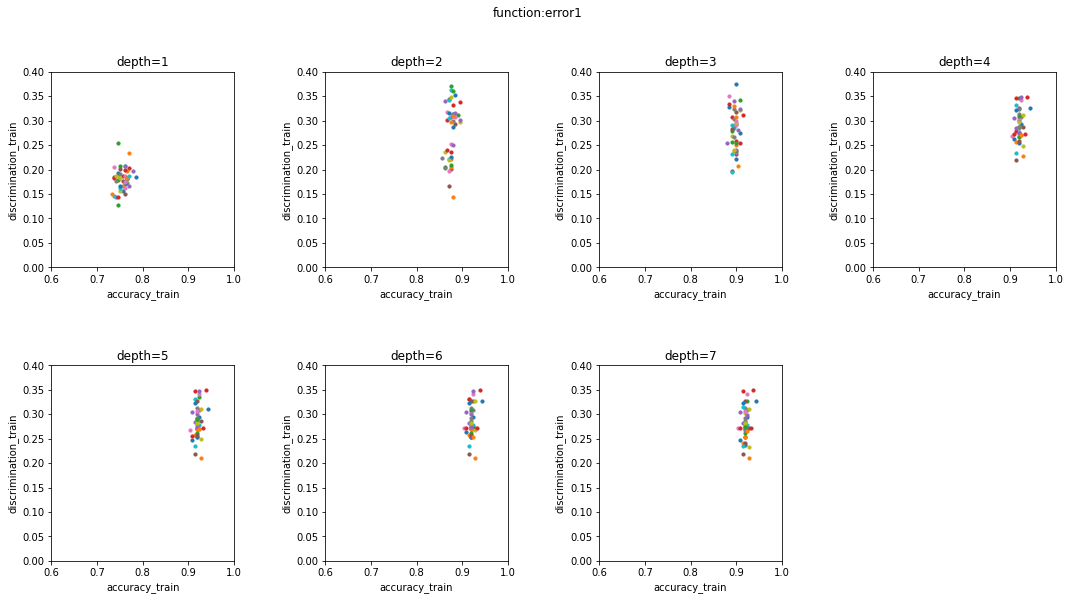

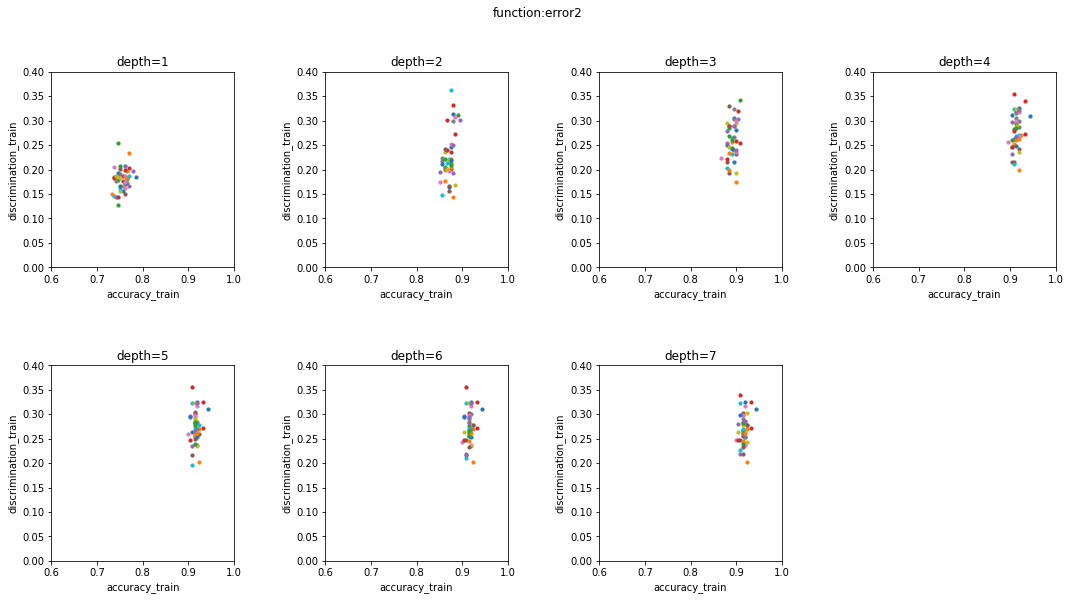

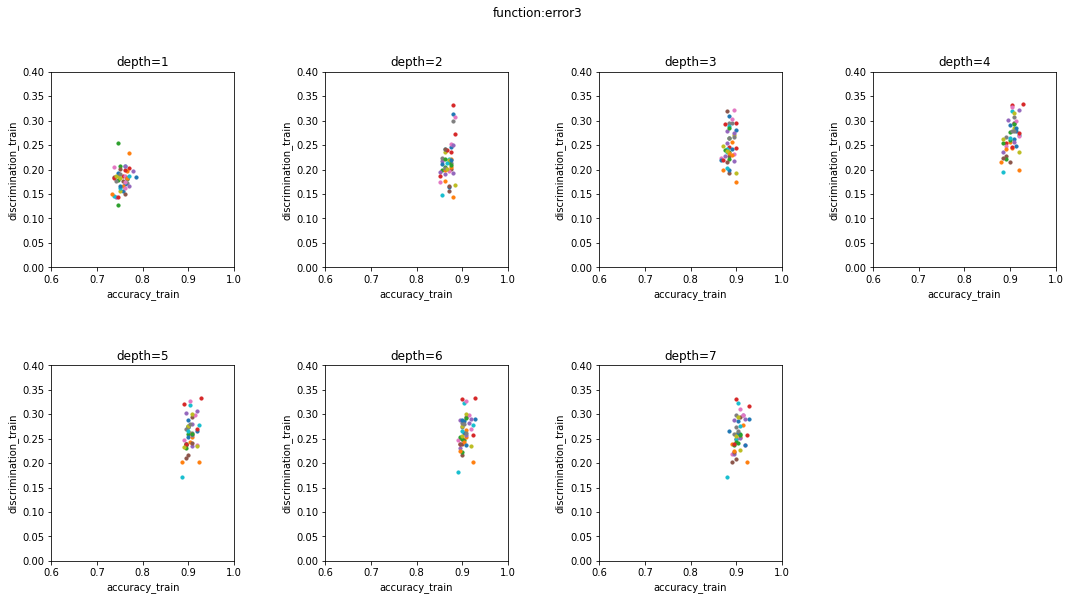

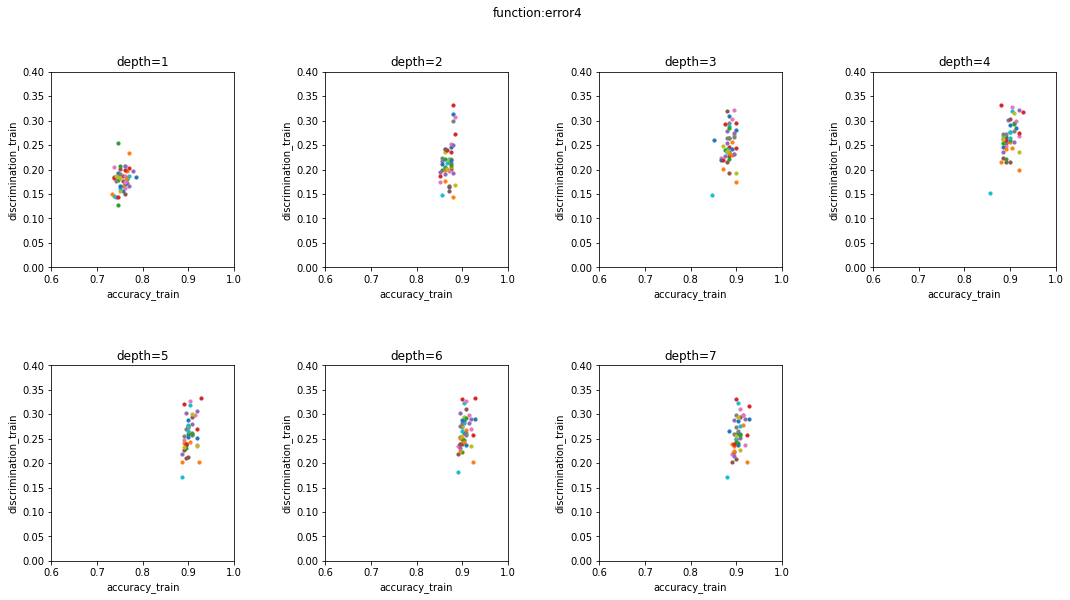

In [17]:
from matplotlib.pyplot import suptitle


def sss(x_axe, y_axe, r):
    r = r.loc[r["min_supp"] == 1]
    for function in ["error", "error1", "error2", "error3", "error4"]:
        fig, axes= plt.subplots(nrows = 2, ncols = 4, figsize=(18, 9))
        for depth in r['depth'].unique():
            if depth > 4:
                ax = axes[1][depth-5]
            else:
                ax = axes[0][depth-1]
            rr = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            x = rr[x_axe].tolist()
            y = rr[y_axe].tolist()
            for i in range(0, len(x)):
                ax.set_ylim(0, 0.4)
                ax.set_xlim(0.6, 1)
                ax.scatter(x[i], y[i], s=10)
            ax.set_xlabel(x_axe)
            ax.set_ylabel(y_axe)
            ax.title.set_text('depth='+str(depth))
        fig.delaxes(axes[1][3])
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        suptitle('function:' +function)
        plt.show()
sss("accuracy_train", "discrimination_train", result)

In [18]:
from pprint import pprint

clf = DL85Classifier(max_depth=2, error_function=lambda tids: error(list(tids)), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 2,
          'left': {'error': 13.0,
                   'proba': [0.59375, 0.40625],
                   'transactions': [129,
                                    131,
                                    132,
                                    133,
                                    134,
                                    136,
                                    138,
                                    140,
                                    143,
                                    147,
                                    150,
                                    153,
                                    155,
                                    156,
                                    158,
                                    160,
                                    161,
                                    162,
                                    163,
                                    164,
                                    165,
                        

In [19]:
import graphviz
# print the tree
dot = clf.export_graphviz()
graph = graphviz.Source(dot, format="png")
graph.render("plots/lawsuit_k_error")

'plots/lawsuit_k_error.png'

In [20]:
clf = DL85Classifier(max_depth=2, error_function=lambda tids: error4(list(tids)), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
pprint(clf.error_)
pprint(clf.tree_)

350.61908
{'feat': 9,
 'left': {'feat': 2,
          'left': {'error': 17.476191,
                   'proba': [0.59375, 0.40625],
                   'transactions': [129,
                                    131,
                                    132,
                                    133,
                                    134,
                                    136,
                                    138,
                                    140,
                                    143,
                                    147,
                                    150,
                                    153,
                                    155,
                                    156,
                                    158,
                                    160,
                                    161,
                                    162,
                                    163,
                                    164,
                                    165,
         

In [21]:
import graphviz
# print the tree
dot = clf.export_graphviz()
graph = graphviz.Source(dot, format="png")
graph.render("plots/lawsuit_k_error4")

'plots/lawsuit_k_error4.png'